In [ ]:
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, auc
import skfuzzy as fuzz
import QFIE.FuzzyEngines as FE
from skfuzzy.defuzzify.exceptions import EmptyMembershipError
import membership
import rule_base
import mamdani
import wangmendel
import defuzz
from Examples.MackeyGlass import synthetic
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8



from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="b7afa0f6888a2e6bff61cf4fd18c145d7f8cf5edf7981f8a2878e166221e621fd66aa7e40c9c5c89a9f41265f5f304b96c17ae5d44b98802f976a31f0c311b56",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)

In [59]:
df = pd.read_csv("./data_2/relevant_features_GHS.csv")


X = df.drop(columns=["attack"]).values  
y = df["attack"].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Numero di etichette 0 in y_test:", np.sum(y_test == 0))
print("Numero di etichette 1 in y_test:", np.sum(y_test == 1))

X_train shape: (10048, 2)
y_train shape: (10048,)
X_val shape: (2512, 2)
y_val shape: (2512,)
X_test shape: (3140, 2)
y_test shape: (3140,)
Numero di etichette 0 in y_test: 3000
Numero di etichette 1 in y_test: 140


(10048,)


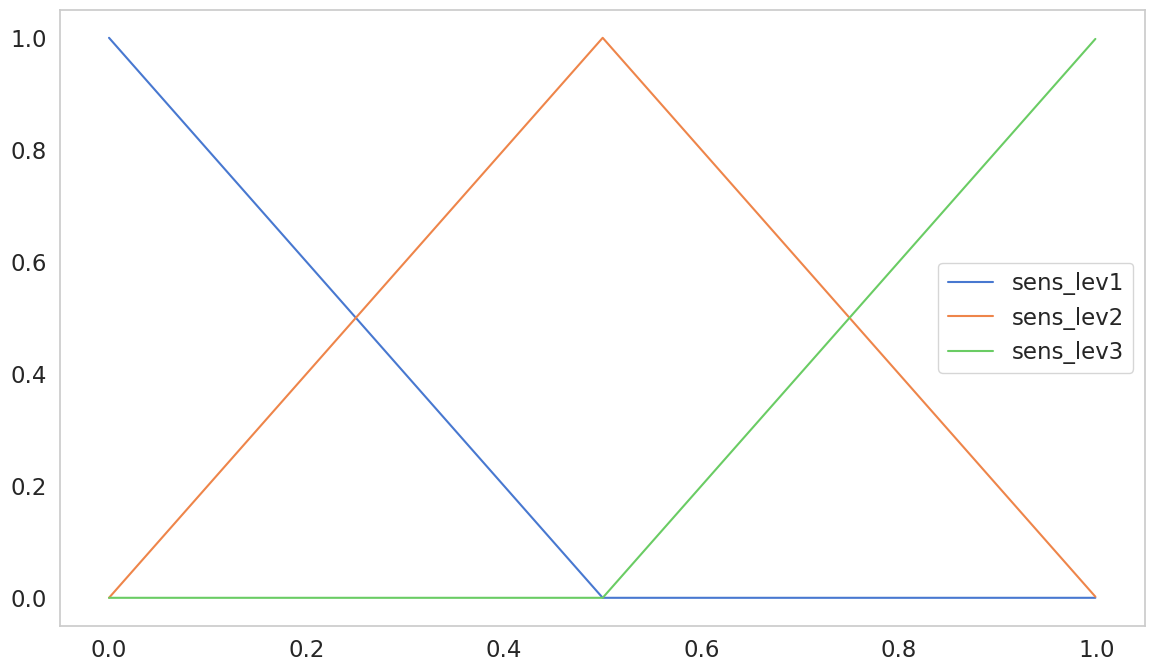

In [60]:
A = np.array(X_train)[:,0]
print(A.shape)

n_regions = 3
name_preffix = 'sens_lev'

fuzzy_regions = wangmendel.get_fuzzy_regions(A, n_regions, name_preffix)

# First we need to define the range of values on X-axis
ini = min(A)
end = max(A)

x = np.arange(ini, end, 0.001)

for region in fuzzy_regions:
    pertinence = np.vectorize(region.set.pertinence, otypes=[float])
    plt.plot(x, pertinence(x), label=region.name)
    
plt.legend()
plt.grid()

In [61]:
for region in fuzzy_regions:
    print(region)

sens_lev1 = inf_border(x, 0.0, 0.5)
sens_lev2 = triang(x, 0.0, 0.5, 1.0)
sens_lev3 = sup_border(x, 0.5, 1.0)


In [62]:
rule_base = wangmendel.learn_fuzzy_rules(X_train, y_train,
                                        n_regions_inputs=[3,3],
                                        n_regions_output=2,
                                        name_preffix_inputs=['dT_rand', 'HT_temperature.T'],
                                        name_preffix_output='Y')

In [63]:
print("The rule base has {} rules!".format(rule_base.size()))

The rule base has 10048 rules!


In [64]:
rule_base = wangmendel.clean_rule_base(rule_base)
print("The cleaned rule base has {} rules!".format(rule_base.size()))

The cleaned rule base has 29 rules!


In [65]:
def calculate_reconstruction_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

errors = []
y_pred = []

for x in X_test:
    y, f_y = mamdani.predict_crisp(x, rule_base)
    predicted_value = defuzz.centroid(y, f_y)
    y_pred.append(predicted_value)
    error = calculate_reconstruction_error([y_test[len(y_pred) - 1]], [predicted_value])
    errors.append(error)

threshold = np.percentile(errors, 96)
print(f"Threshold for anomaly detection: {threshold}")

# Identificare le anomalie
anomalies = [error > threshold for error in errors]
print(f"Anomalies detected: {sum(anomalies)} out of {len(errors)}")

Threshold for anomaly detection: 0.14640726578815164
Anomalies detected: 125 out of 3140


In [66]:
# Plot dei risultati
plt.plot(y_test, color='blue', label='True values')
plt.plot(y_pred, '--', color='red', label='Predicted values')
plt.legend()
plt.title("Anomaly Detection with Wang-Mendel Fuzzy Rules")
plt.show()

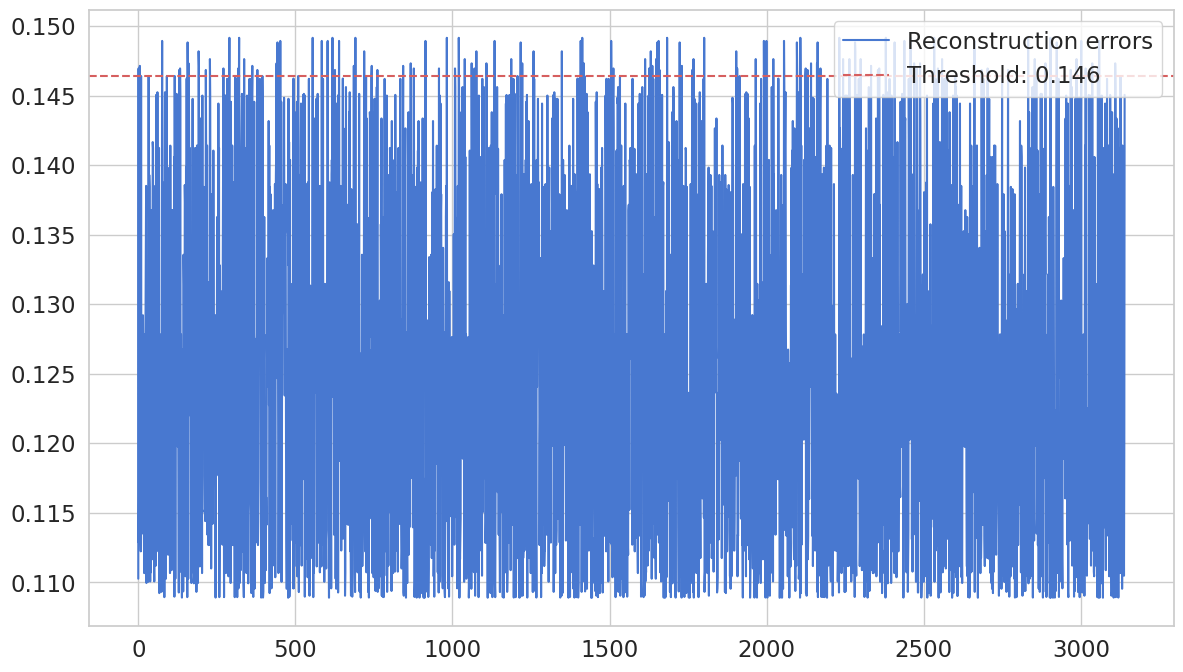

In [67]:
# Mostra le anomalie nel test set
threshold_str = str(threshold)  # Converti in stringa
threshold_str = threshold_str[:threshold_str.find('.') + 4]  # Prendi solo le prime 2 cifre dopo la virgola

plt.plot(errors, label='Reconstruction errors')
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold_str}")
plt.legend()
plt.show()

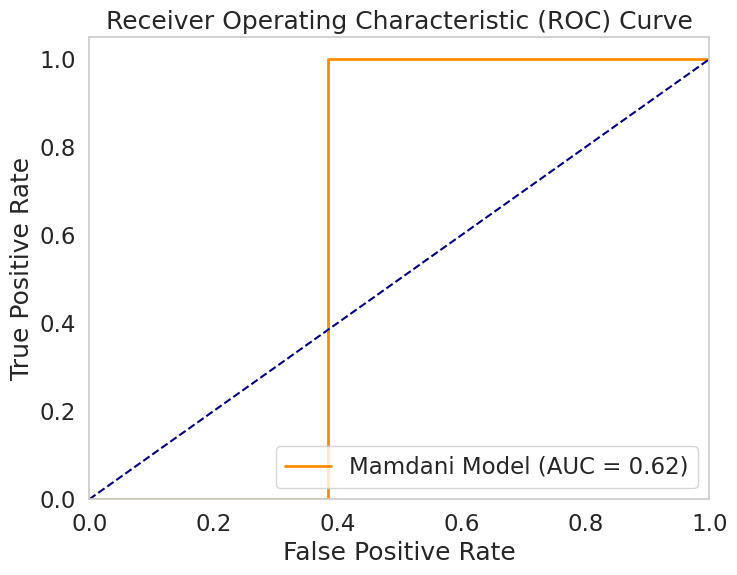

In [68]:
fpr, tpr, _ = roc_curve(y_test, np.array(errors))
roc_auc = auc(fpr, tpr)

# Disegnare la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Mamdani Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonale random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [69]:
def map_fuzzy_set_antecedent(fuzzy_set):
        if "triang" in fuzzy_set.__str__():
            return "medium"
        elif "inf_border" in fuzzy_set.__str__():
            return "low"
        elif "sup_border" in fuzzy_set.__str__():
            return "high"

In [70]:
rule_list = []
for i in range(rule_base.size()):
    rule_list.append(rule_base.printRule(i))
print(rule_list)

[([['dT_rand1', inf_border(x, 0.0, 0.5)], ['HT_temperature.T1', inf_border(x, 0.0571336743281047, 157.97551202766405)]], ['Y1', inf_border(x, 0, 1.0)], 0.9973850323520028), ([['dT_rand3', sup_border(x, 0.5, 1.0)], ['HT_temperature.T3', sup_border(x, 157.97551202766405, 315.893890381)]], ['Y2', sup_border(x, 0.0, 1)], 0.6724753379820001), ([['dT_rand2', triang(x, 0.0, 0.5, 1.0)], ['HT_temperature.T1', inf_border(x, 0.0571336743281047, 157.97551202766405)]], ['Y1', inf_border(x, 0, 1.0)], 0.9954672853785232), ([['dT_rand1', inf_border(x, 0.0, 0.5)], ['HT_temperature.T1', inf_border(x, 0.0571336743281047, 157.97551202766405)]], ['Y1', inf_border(x, 0, 1.0)], 0.9971303119024278), ([['dT_rand2', triang(x, 0.0, 0.5, 1.0)], ['HT_temperature.T1', inf_border(x, 0.0571336743281047, 157.97551202766405)]], ['Y1', inf_border(x, 0, 1.0)], 0.994758876411821), ([['dT_rand1', inf_border(x, 0.0, 0.5)], ['HT_temperature.T1', inf_border(x, 0.0571336743281047, 157.97551202766405)]], ['Y1', inf_border(x, 0,

In [71]:
def map_fuzzy_set_antecedent(fuzzy_set):
    fuzzy_str = str(fuzzy_set)
    if "triang" in fuzzy_str:
        return "medium"
    elif "inf_border" in fuzzy_str:
        return "low"
    elif "sup_border" in fuzzy_str:
        return "high"
    return "unknown"  # Default nel caso non corrisponda a nessuna categoria

linguistic_rules = []
for antecedent_list, consequent_data, strength in rule_list:
    antecedent_str_parts = []
    
    # Rimuoviamo solo l'ultimo numero dai sensori
    for var, fuzzy_set in antecedent_list:
        # Rimuove solo l'ultimo numero dalla fine del nome del sensore
        var_clean = re.sub(r'(\d)$', '', var)  # Rimuove solo l'ultimo numero
        antecedent_str_parts.append(f"{var_clean} is {map_fuzzy_set_antecedent(fuzzy_set)}")
    
    antecedent_str = " and ".join(antecedent_str_parts)
    
    # Modifica il conseguente
    consequent_var, consequent_fuzzy_set = consequent_data
    consequent_var = "Y1" if consequent_var == "Y2" else consequent_var
    consequent_str = f"{consequent_var} is normal"
    
    # Crea la regola linguistica
    rule_str = f"if {antecedent_str} then {consequent_str}"
    linguistic_rules.append(rule_str)

# Rimuove eventuali duplicati e stampa le regole
rules = list(set(rule.strip() for rule in linguistic_rules))

for rule in rules:
    print(rule)

if dT_rand is medium and HT_temperature.T is low then Y1 is normal
if dT_rand is high and HT_temperature.T is high then Y1 is normal
if dT_rand is low and HT_temperature.T is low then Y1 is normal
if dT_rand is high and HT_temperature.T is low then Y1 is normal


In [ ]:
sens_1 = np.linspace(0, 1, 10)
sens_2 = np.linspace(0, 1, 10)
Y1 = np.linspace(0, 0, 1)

# Aggiunto un margine del 5% ai valori minimi e massimi
margin_sens1 = 0.05 * (1 - 0)  # 5% dell'intervallo [0,1]
margin_sens2 = 0.05 * (1 - 0)

# Intervalli rilassati per sens_1
a_sens1 = 0 - margin_sens1
b_sens1 = 0.3  
c_sens1 = 1 + margin_sens1  

# Intervalli rilassati per sens_2
a_sens2 = 0 - margin_sens2
b_sens2 = 0.5  
c_sens2 = 1 + margin_sens2  

# Funzioni di appartenenza per sens_1 (con intervalli rilassati)
mf1_sens1 = fuzz.trimf(sens_1, [a_sens1, a_sens1, b_sens1])  
mf2_sens1 = fuzz.trimf(sens_1, [b_sens1, (b_sens1 + c_sens1) / 2, c_sens1])  
mf3_sens1 = fuzz.trimf(sens_1, [0.8 * c_sens1, c_sens1, c_sens1 + margin_sens1])  

# Funzioni di appartenenza per sens_2 (con intervalli rilassati)
mf1_sens2 = fuzz.trimf(sens_2, [a_sens2, a_sens2, b_sens2])  
mf2_sens2 = fuzz.trimf(sens_2, [b_sens2, (b_sens2 + c_sens2) / 2, c_sens2])  
mf3_sens2 = fuzz.trimf(sens_2, [0.9 * c_sens2, c_sens2, c_sens2 + margin_sens2]) 

# Funzione di appartenenza per Y1
mf1_Y1 = fuzz.trimf(Y1, [0, 0, 1])

qfie = FE.QuantumFuzzyEngine(verbose=False)
qfie.input_variable(name='dT_rand', range=sens_1)
qfie.input_variable(name='HT_temperature.T', range=sens_2)
qfie.output_variable(name='Y1', range=Y1)
qfie.add_input_fuzzysets(var_name='dT_rand', set_names=['low', 'medium', 'high'], sets=[mf1_sens1, mf2_sens1, mf3_sens1])
qfie.add_input_fuzzysets(var_name='HT_temperature.T', set_names=['low', 'medium', 'high'], sets=[mf1_sens2, mf2_sens2, mf3_sens2])
qfie.add_output_fuzzysets(var_name='Y1', set_names=['normal'],sets=[mf1_Y1])

#RULES GENERATED BY PSO (TRAINING) and PATTERN SEARCH (TUNING):

rules_1 = ['if HT_temperature.T is low then Y1 is normal', 
           'if HT_temperature.T is medium then Y1 is normal',
           'if dT_rand is high and HT_temperature.T is low then Y1 is normal',
           'HT_temperature.T is high then Y1 is normal']

#RULES GENERATED BY PSO (TRAINING) and Simulated Annealing (TUNING):

rules_2 = ['if HT_temperature.T is medium then Y1 is normal', 
           'if dT_rand is low and HT_temperature.T is low then Y1 is normal',
           'if dT_rand is medium and HT_temperature.T is low then Y1 is normal',
           'if dT_rand is medium and HT_temperature.T is high then Y1 is normal']
    
#RULES GENERATED BY Genetic Algorithm (TRAINING) and Pattern Search (TUNING):
    
rules_3 =  ['if HT_temperature.T is low then Y1 is normal', 
           'if  HT_temperature.T is medium then Y1 is normal',
           'if dT_rand is high and HT_temperature.T is low then Y1 is normal',
           'if HT_temperature.T is high then Y1 is normal']

#RULES GENERATED BY Genetic Algorithm (TRAINING) and Simulated Annealing(TUNING):

rules_4 = ['if HT_temperature.T is medium then Y1 is normal', 
           'if dT_rand is low and HT_temperature.T is low then Y1 is normal',
           'if dT_rand is medium and HT_temperature.T is low then Y1 is normal',
           'if dT_rand is medium and HT_temperature.T is high then Y1 is normal']

qfie.set_rules(rules)

In [ ]:
f_quantum = []
i = 0
errors = []
# Threshold FISSO per rilevare anomalie basato sull'errore di ricostruzione
THRESHOLD = 0.6
    
for row in X_test: 
    
    input_values = {
        'dT_rand': row[0],
        'HT_temperature.T': row[1]
    }
        
        
    # Costruct Quantum Circuit for Inference
    qfie.build_inference_qc(input_values, draw_qc=True, filename=f"q_rules_4/quantum_GHS_rule.pdf")
    i = i + 1
            
    try:
        # Quantum Inference
        predicted_value = qfie.execute(n_shots=1000, plot_histo=True)[0] #backend=FakeTorino()

        # Calcolo dell'errore di ricostruzione rispetto all'etichetta reale
        error = mean_squared_error([y_test[i - 1]], [predicted_value])

        # Salvataggio dell'errore
        errors.append(error)

        # Se l'errore supera la soglia fissa, assegniamo l'etichetta 1 (anomalia)
        if error > THRESHOLD:
            result = 1
        else:
            result = predicted_value
    except EmptyMembershipError:
            # Se l'errore EmptyMembershipError si verifica, assegniamo direttamente l'etichetta 1
            result = 1
            errors.append(THRESHOLD + 0.01)  # Se l'errore si verifica, inseriamo l'etichetta 1

    f_quantum.append(result)

draw
                    ┌──────────────────────────────────┐                ░ ┌───┐»
         dT_rand_0: ┤0                                 ├───────■────────░─┤ X ├»
                    │  Initialize(0,0.65576,0,0.75497) │┌───┐  │  ┌───┐ ░ └───┘»
         dT_rand_1: ┤1                                 ├┤ X ├──■──┤ X ├─░──────»
                    ├──────────────────────────────────┤├───┤  │  ├───┤ ░ ┌───┐»
HT_temperature.T_0: ┤0                                 ├┤ X ├──■──┤ X ├─░─┤ X ├»
                    │  Initialize(0,0.59587,0,0.80308) │├───┤  │  ├───┤ ░ └───┘»
HT_temperature.T_1: ┤1                                 ├┤ X ├──■──┤ X ├─░──────»
                    └──────────────────────────────────┘└───┘┌─┴─┐└───┘ ░      »
                Y1: ─────────────────────────────────────────┤ X ├──────░──────»
                                                             └───┘      ░      »
             c55: 1/═══════════════════════════════════════════════════════════»
                       

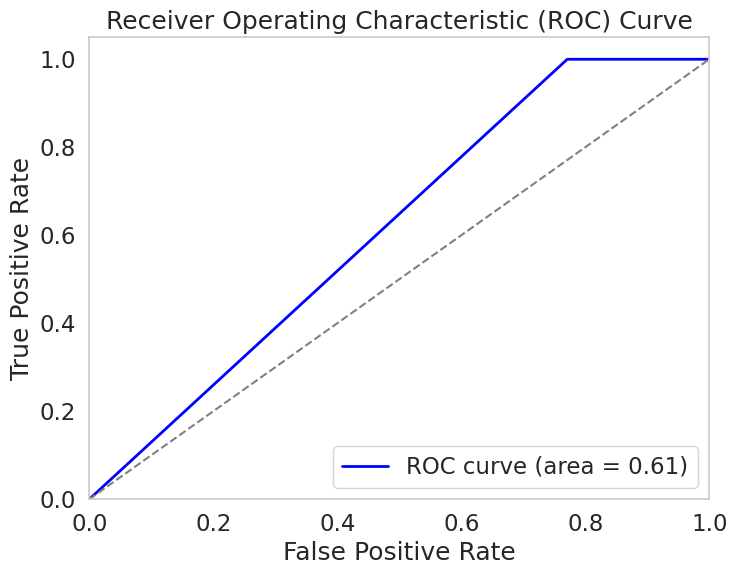

In [76]:
fpr, tpr, _ = roc_curve(y_test, np.array(f_quantum))
roc_auc = auc(fpr, tpr)

# Disegno della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linea diagonale per riferimento
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig("q_rules_4/roc_curve.png", dpi=300, bbox_inches='tight')